In [1]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob


import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [3]:
# Retrieve patient names and loop through them
patient_list = [f"TNBC{i}" for i in range(1, 97)]

patients_to_remove = []
for patient in patient_list:
    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        

        for name in names:
            # print(opti_clusters.loc[name, 'n_clusters'])

            file = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            if os.path.exists(file) == False:
                patients_to_remove.append(patient)
                print(f"Removed patient {patient} as {file} does not exist")
                
            # labels = pd.read_csv(glob.glob(os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans", name, f"invasive_labels_{opti_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist_*.csv"))[0], index_col=0)

            # labels["patient"] = [idx.split("_")[0] for idx in labels.index]
            # # Group by patient and get statistics
            # patient_stats = labels.groupby("patient").agg({
            #     'predicted_label': ['nunique', 'count']
            # }).reset_index()

            # # Flatten column names
            # patient_stats.columns = ['patient', 'n_unique_labels', 'n_rows']

                
            # other_patients_to_remove = patient_stats[(patient_stats["n_rows"] < 100) | (patient_stats["n_unique_labels"] < 3)]
            # for patient in other_patients_to_remove["patient"].values:
            #     patients_to_remove.append(patient)
                

# remove all patients in patients_to_remove from patient_list
patients_to_remove_set = set(patients_to_remove)
original_len = len(patient_list)
patient_list = [p for p in patient_list if p not in patients_to_remove_set]
print(f"Removed {original_len - len(patient_list)} patients; remaining {len(patient_list)} patients.")

Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_5_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_4096_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_explora_kde_4096_prototypes_7_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_16384_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_explora_kde_16384_prototypes_6_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_65536_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_un

In [4]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []

    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        


        for name in names:

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            # filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_*_clusters_patient_{patient}.csv"))
            # if len(filenames) == 0:
            #     print(f"No file found for {name}, {model_type}")
            # filename = filenames[0]
            print(filename)
            df = pd.read_csv(filename, index_col=0)


            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params,
                                "patient": patient})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_raw_filtered_normalized_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()


../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_5_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_4096_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_explora_kde_4096_prototypes_7_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_16384_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_explora_kde_16384_prototypes_6_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_65536_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_explora_kde_65536_prototypes_4_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explor

In [5]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

print("Original order:", retrained_models)
print("Sorted order:", sorted_retrained_models)


palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

Original order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']
Sorted order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']


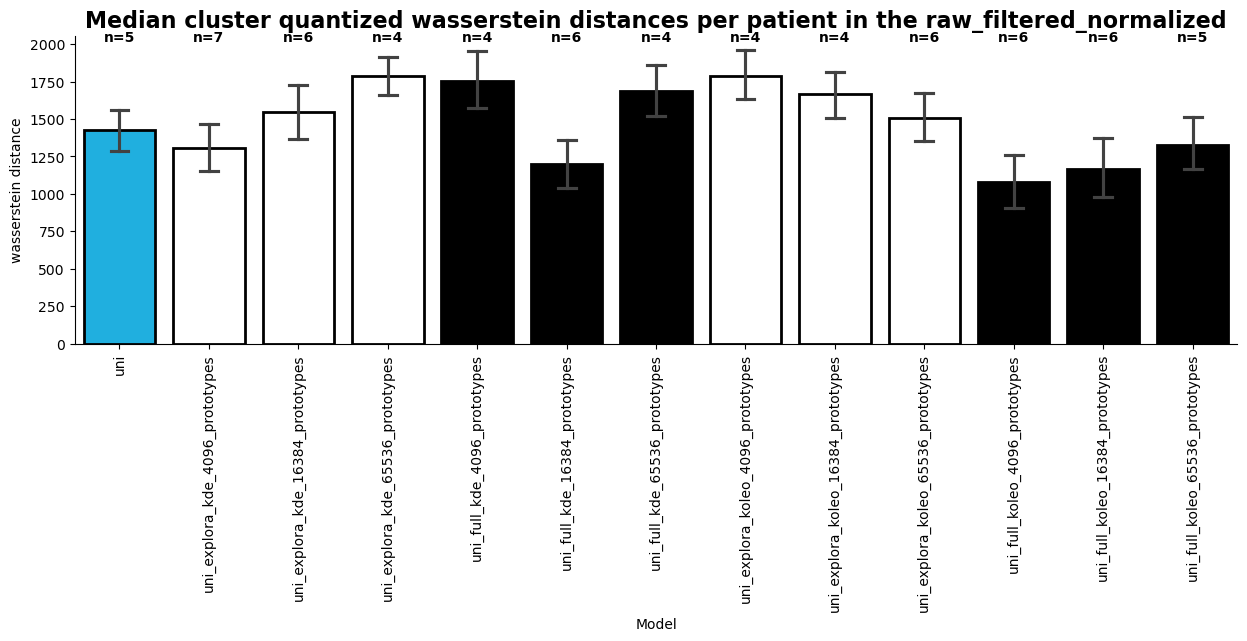

In [6]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
# palette=["deepskyblue", "white", "white", "white","black", 
#           "black", "black", "white", "white", "white", 
#         "black", "black", "black", ],
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=2000, s=f"n={int(n)}", ha='center', va='bottom', weight='bold')




plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_normalized_embedding_per_patient.pdf"), bbox_inches='tight')

In [7]:
uni_distances = df[df["model"] == "uni"]["wasserstein_distances"].values
# Flatten the nested arrays completely
uni_distances = np.concatenate(uni_distances)

t_uni_distances = np.concatenate(df[df["model"] == "uni_full_koleo_4096_prototypes"]["wasserstein_distances"].values)

print(f"UNI: {len(uni_distances)} ;  T-UNI: {len(t_uni_distances)}")

UNI: 369 ;  T-UNI: 669


<Axes: xlabel='max_wasserstein_distance', ylabel='Density'>

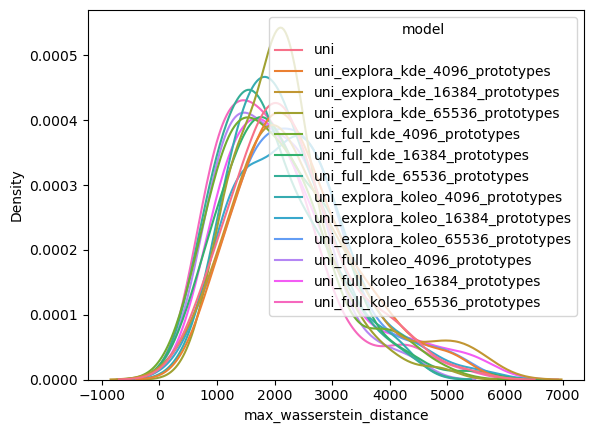

In [8]:
sns.kdeplot(df, x="max_wasserstein_distance", hue="model",  common_norm=False)

In [9]:
optimal_clusters = []
df_all_summary = []


for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []


    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        
        


        for name in names:

            # print(f"model_type: {name}, optimal clusters: {opti_clusters.loc[name, 'n_clusters']}")

            
        # print(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv"))
            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            
            # print(filename)
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
# stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()




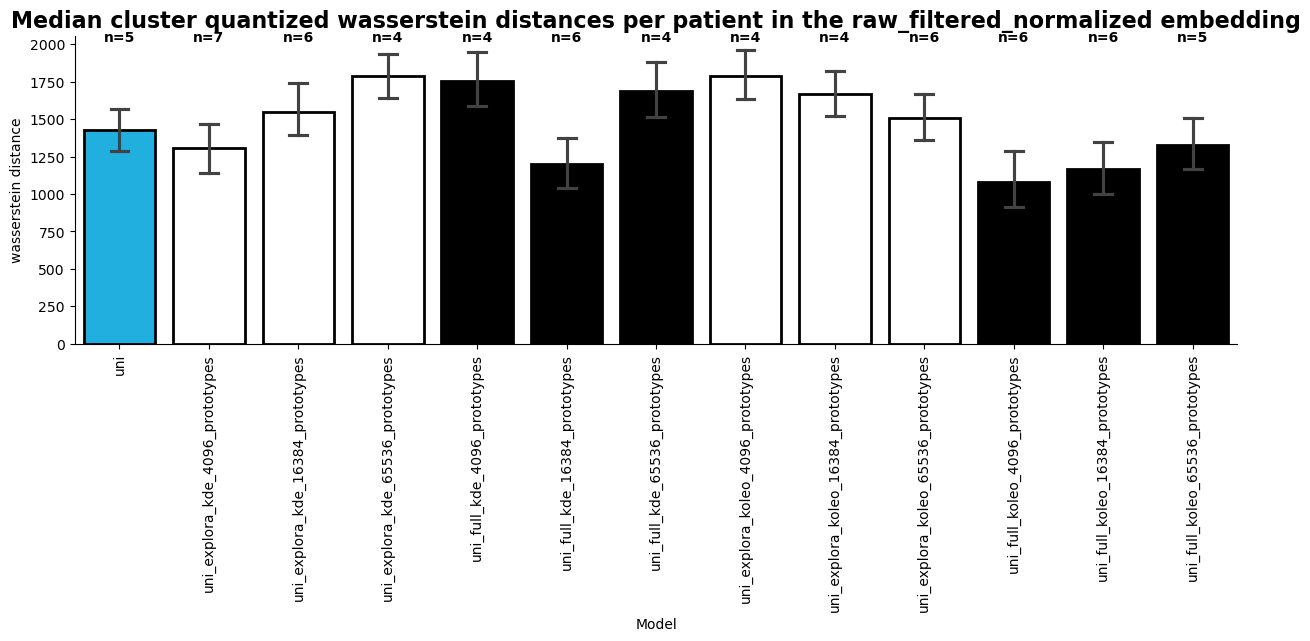

In [10]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=2000, s=f"n={n}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_embedding_per_patient.pdf"), bbox_inches='tight')

In [11]:
final_values = {}

for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    dfs = []
    optimal_clusters.append(opti_clusters)
    


    for name in names:
        n_clusters = opti_clusters.loc[name, 'n_clusters']

        labels_file = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans",
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]
        labels = pd.read_csv(labels_file, index_col=0)
        labels['patient_id'] = labels.index.str.split('_').str[0]
        labels_counts = labels['patient_id'].value_counts()
    
        patients_low_counts = labels_counts[labels_counts < 2000].index.tolist()
        
        patients_files = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_*.csv"))
        patients = [os.path.basename(patient_file).split("_clusters_patient_")[1].split('.csv')[0] for patient_file in patients_files]
        patients = [patient for patient in patients if patient not in patients_low_counts]
        
        patients_dict = {}
        for i_p, patient in enumerate(['TNBC25', 'TNBC93', 'TNBC83', 'TNBC52', 'TNBC41', 'TNBC3', 'TNBC72',
       'TNBC94', 'TNBC50', 'TNBC92']):
            

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))

            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))

            lower_matrix.columns = [int(col) for col in lower_matrix.columns]
            patients_dict[patient] = lower_matrix.stack().to_dict()
    
        # Aggregate patient dictionaries with normalized keys
        aggregated_dict = {}

        for patient, patient_data in patients_dict.items():
            for (i, j), value in patient_data.items():
                # Normalize the key so (i,j) and (j,i) are treated the same
                # Always use the smaller index first
                normalized_key = tuple(sorted([i, j]))
                
                if normalized_key not in aggregated_dict:
                    aggregated_dict[normalized_key] = []
                
                aggregated_dict[normalized_key].append(value)


        mean_dict = {k: np.mean(v) for k, v in aggregated_dict.items()}
        distances = list(mean_dict.values())
        final_values[name] = distances

Text(0.5, 1.0, 'Median of the mean wasserstein distance of cluster pairs across patients')

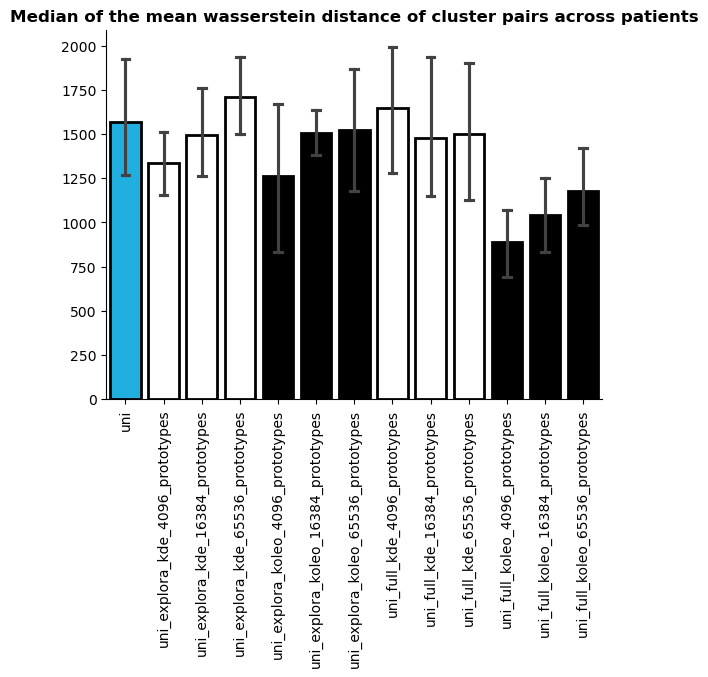

In [12]:
sns.barplot(final_values, palette=["deepskyblue", 
         "white", "white", "white", 
         "black", "black", "black", 
         "white", "white", "white", 
         "black", "black","black", ],                      
            linewidth=2,
            edgecolor="black", capsize=0.2)
plt.xticks(rotation=90)
sns.despine()
plt.title("Median of the mean wasserstein distance of cluster pairs across patients", weight='bold')


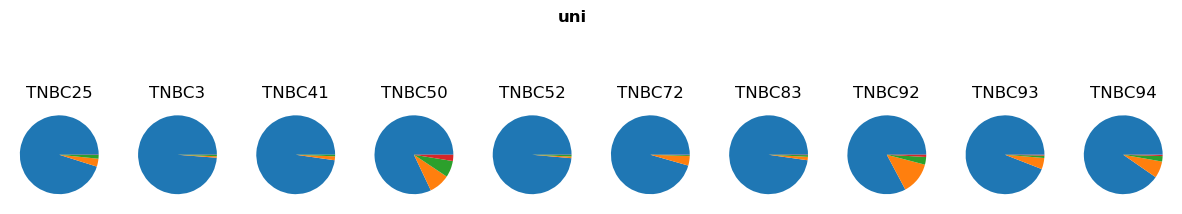

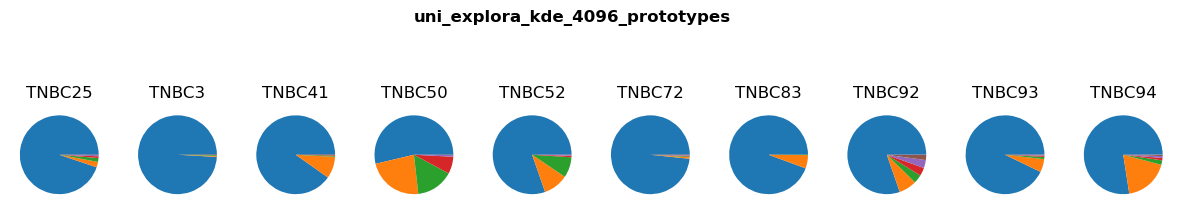

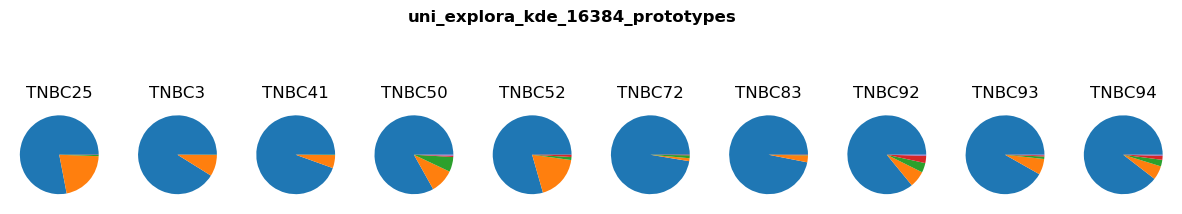

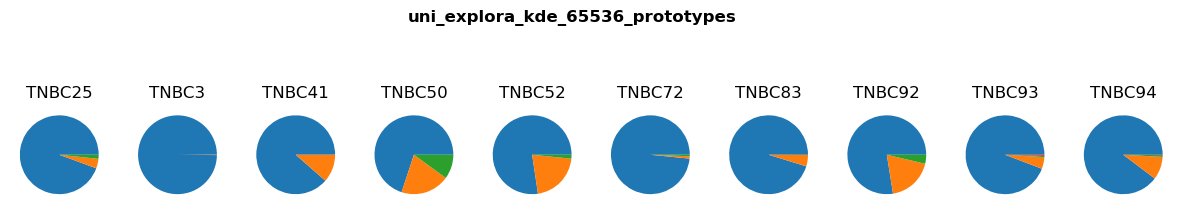

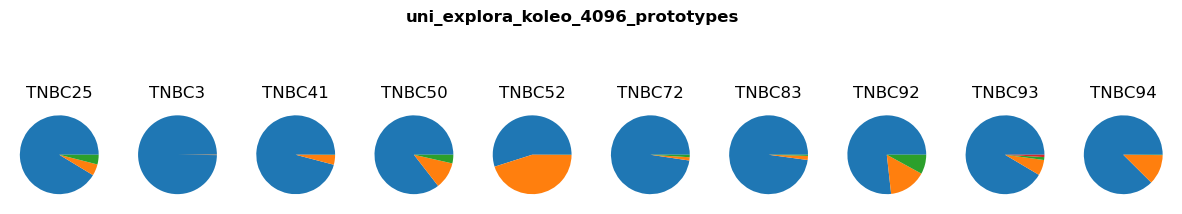

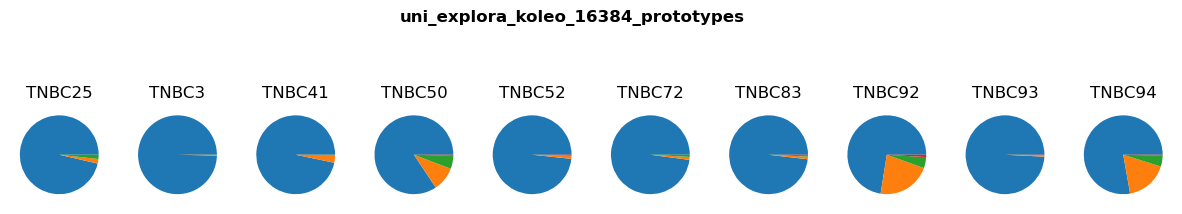

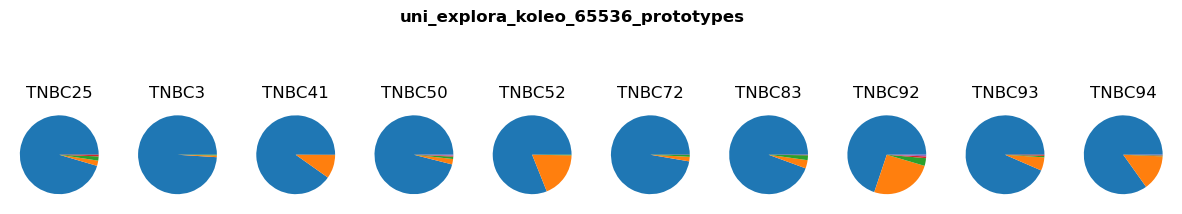

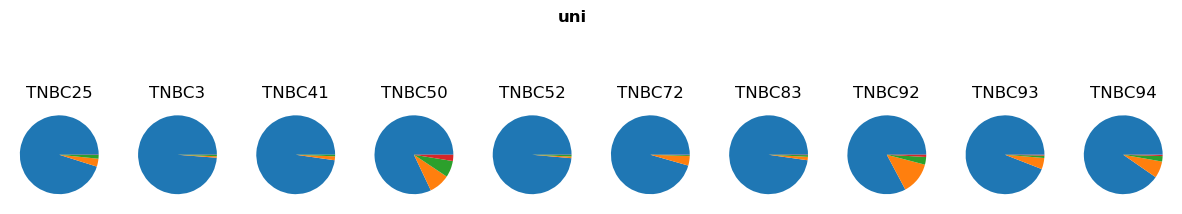

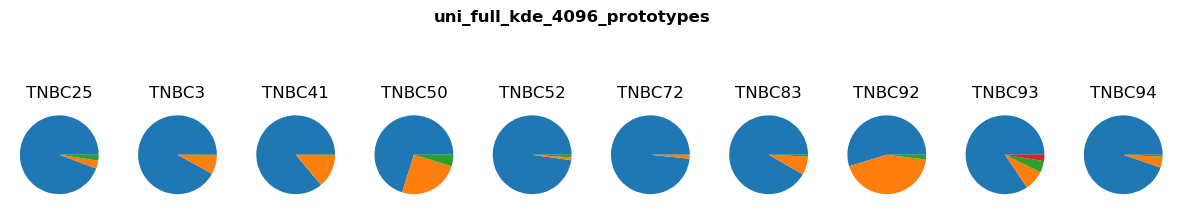

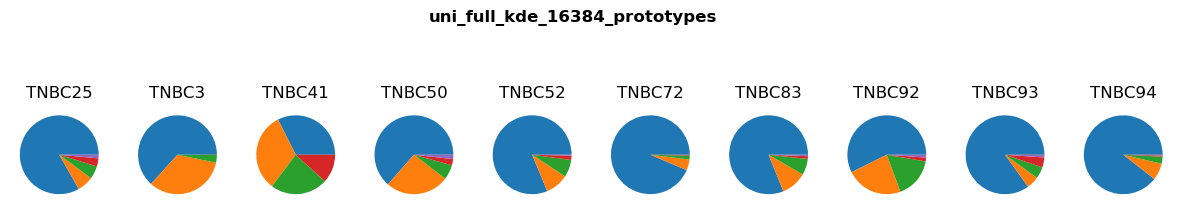

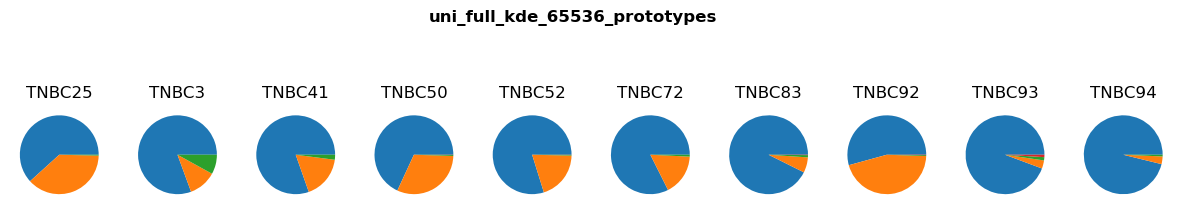

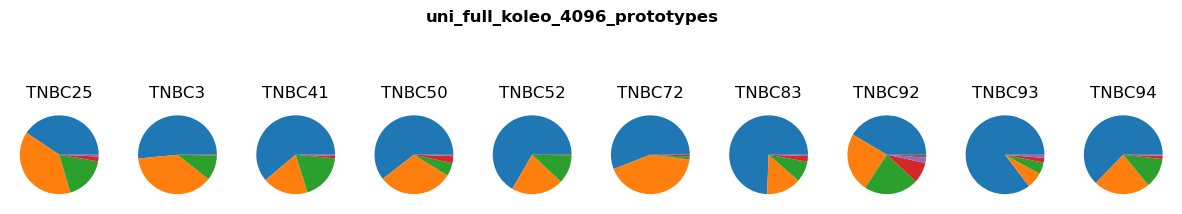

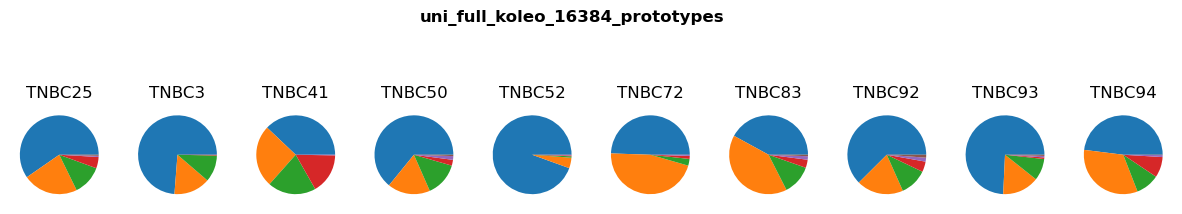

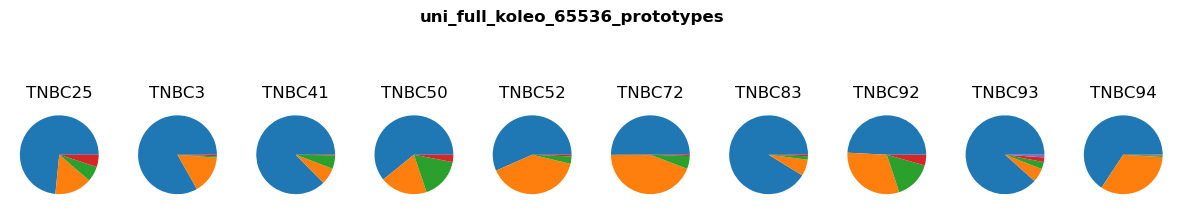

In [13]:
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    dfs = []
    optimal_clusters.append(opti_clusters)
    
    for name in names:
        n_clusters = opti_clusters.loc[name, 'n_clusters']

        labels_file = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans",
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]
        labels = pd.read_csv(labels_file, index_col=0)
        labels['patient_id'] = labels.index.str.split('_').str[0]
        labels = labels[labels["patient_id"].isin(['TNBC25', 'TNBC93', 'TNBC83', 'TNBC52', 'TNBC41', 'TNBC3', 'TNBC72',
       'TNBC94', 'TNBC50', 'TNBC92'])]
        plt.figure(figsize=(15, 3))
        i = 1
        for patient in labels["patient_id"].unique():
            plt.subplot(1, labels["patient_id"].nunique(), i)
            i += 1
            plt.pie(labels[labels["patient_id"] == patient].value_counts("predicted_label"));


            # top_counts = counts.nlargest(15)
            # other_count = counts.sum() - top_counts.sum()

            # sizes = top_counts.values.tolist()
            # labels_names = top_counts.index.tolist()
            # if other_count > 0:
            #     sizes.append(other_count)
            #     labels_names.append("Other")

            # palette_local = sns.color_palette("hls", n_colors=len(labels_names))
            # wedges, texts, autotexts = ax.pie(sizes, colors=palette_local, startangle=90, autopct=lambda p: f"{p:.1f}%" if p > 0 else "")
            # ax.legend(wedges, labels_names, title="Top patients", bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize="small")
            # ax.axis("equal")
            plt.title(f"{patient}")
        plt.suptitle(name, weight='bold')

In [14]:
df_summary = pd.DataFrame(columns=["n_clusters", 
                                   "wasserstein_distances", 
                                   "mean_wasserstein_distance", 
                                   "std_wasserstein_distance", 
                                   "median_wasserstein_distance", 
                                   "min_wasserstein_distance", 
                                   "max_wasserstein_distance",
                                   "model_type",
                                   "params"])
summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()
for model_type, names, path in zip([config['retrained_model_list1_type'],
                             config['retrained_model_list2_type']],
                             [config['retrained_model_list1'],
                              config['retrained_model_list2']],
                              [config['retrained_benchmark_folder1'],
                               config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
    dfs = []

    
    


    for name in names:
        # print(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        # filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_combat_corrected_5_clusters.csv")
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_raw_filtered_normalized_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv")
        # filename = filenames[0]
        
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n

        n_clusters = df.shape[0]      
        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)


        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)

        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({"n_clusters": n_clusters, 
                            "wasserstein_distances": wasserstein_distances, 
                            "mean_wasserstein_distance": mean_wasserstein_distance, 
                            "std_wasserstein_distance": std_wasserstein_distance, 
                            "median_wasserstein_distance": median_wasserstein_distance, 
                            "min_wasserstein_distance": min_wasserstein_distance, 
                            "max_wasserstein_distance": max_wasserstein_distance,
                            "model_type": model_type, 
                            "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names




df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


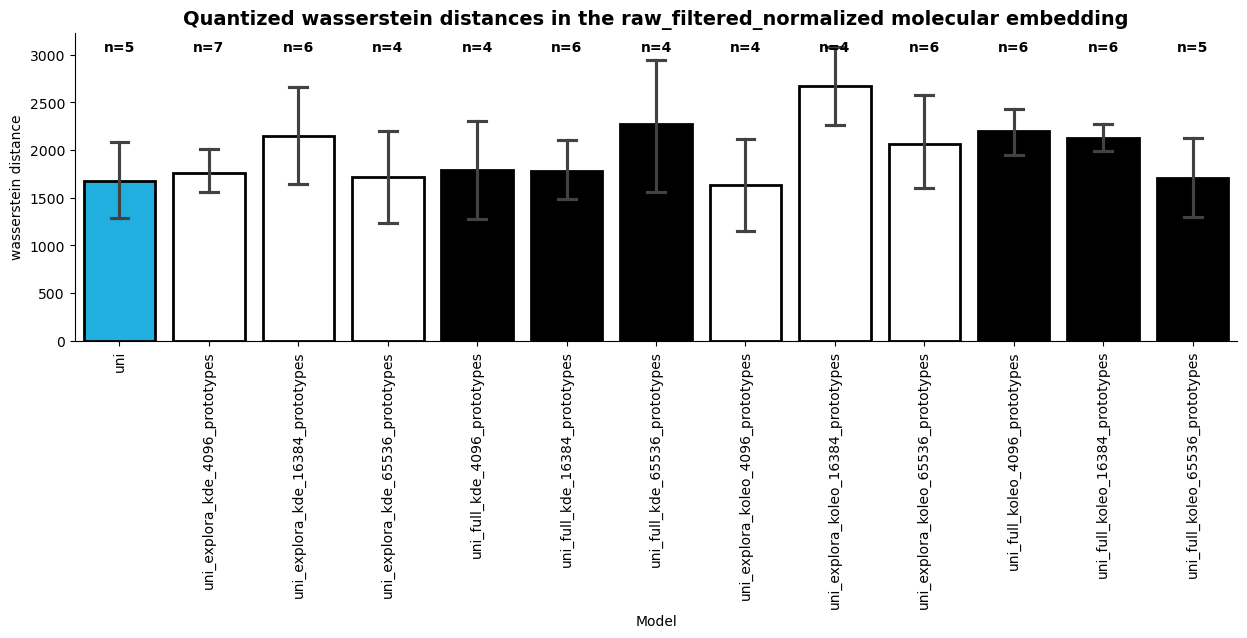

In [15]:
dfs = []
n_clusters = []

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', 
            y="wasserstein_distance", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the raw_filtered_normalized molecular embedding", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=3000, s=f"n={n}", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_molecular_raw_filtered_normalized_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")

In [16]:
from sklearn.metrics import adjusted_rand_score

aris_no_bootstrap = {}
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    dfs = []
    optimal_clusters.append(opti_clusters)
    
    for name in names:
        n_clusters = opti_clusters.loc[name, 'n_clusters']

        labels_file = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans",
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]
        labels = pd.read_csv(labels_file, index_col=0)
        labels['patient_id'] = labels.index.str.split('_').str[0]
        ari = adjusted_rand_score(labels['predicted_label'],
                                  labels['patient_id'])
        aris_no_bootstrap[name] = 1-ari

Text(0.5, 1.0, 'Total batch effect mitigation score (no bootstrap) \n in invasive clusters')

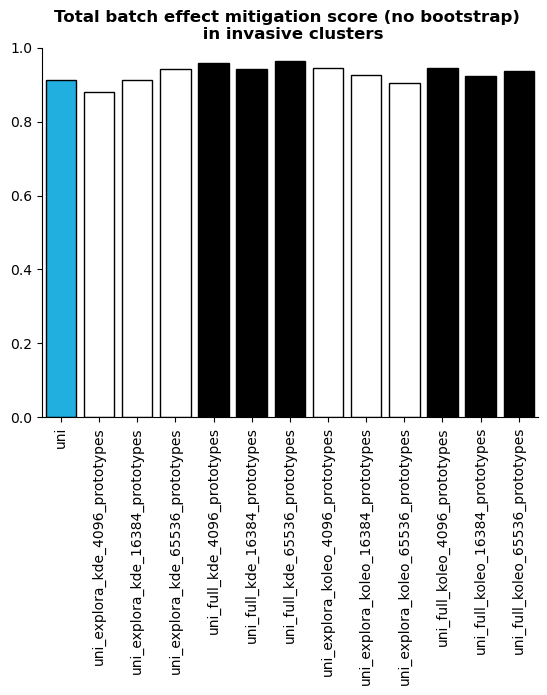

In [17]:
sns.barplot(aris_no_bootstrap, order=sorted_models, palette=palette, edgecolor='black')
plt.xticks(rotation=90)
sns.despine()
plt.ylim(0,1)
plt.title(f"Total batch effect mitigation score (no bootstrap) \n in invasive clusters", weight="bold")

In [18]:
max(aris_no_bootstrap.values()) - min(aris_no_bootstrap.values())

0.08529102837372782